# Retail Demand Forecasting Analysis

This notebook contains the analysis for the ML Zoomcamp 2024 Competition focusing on retail demand forecasting.

## Data Loading

Loading all CSV files from the competition dataset:

In [50]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import lightgbm as lgb
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Load all CSV files
actual_matrix = pd.read_csv('../data/actual_matrix.csv', index_col=0)
catalog = pd.read_csv('../data/catalog.csv', index_col=0)
discounts = pd.read_csv('../data/discounts_history.csv', index_col=0)
markdowns = pd.read_csv('../data/markdowns.csv', index_col=0)
online = pd.read_csv('../data/online.csv', index_col=0)
price_history = pd.read_csv('../data/price_history.csv', index_col=0)
sales = pd.read_csv('../data/sales.csv', index_col=0)
stores = pd.read_csv('../data/stores.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)

## EDA

Key aspects to analyze:
1. Data completeness (missing values)
2. Data types and potential type conversions
3. Value distributions
4. Temporal patterns (for time-series data)
5. Relationships between different datasets

In [4]:
# Display basic information about each dataset
for name, df in {
    'Actual Matrix': actual_matrix,
    'Catalog': catalog,
    'Discounts History': discounts,
    'Markdowns': markdowns,
    'Online': online,
    'Price History': price_history,
    'Sales': sales,
    'Stores': stores,
    'Test': test
}.items():
    print(f"\n{name} Dataset:")
    print(f"Shape: {df.shape}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nSample data:")
    print(df.head(2))
    print("\nData Info:")
    df.info()


Actual Matrix Dataset:
Shape: (35202, 3)

Columns:
['item_id', 'date', 'store_id']

Sample data:
        item_id        date  store_id
0  c578da8e8841  2019-10-17         1
1  4dd2b686802c  2019-10-17         1

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 35202 entries, 0 to 35201
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item_id   35202 non-null  object
 1   date      35202 non-null  object
 2   store_id  35202 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB

Catalog Dataset:
Shape: (219810, 8)

Columns:
['item_id', 'dept_name', 'class_name', 'subclass_name', 'item_type', 'weight_volume', 'weight_netto', 'fatness']

Sample data:
        item_id                 dept_name          class_name  \
0  da17e2d5feda  БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ  БУМАЖНАЯ ПРОДУКЦИЯ   
1  614de2b96018  БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ    ВАТНАЯ ПРОДУКЦИЯ   

      subclass_name item_type  weight_volume  weight_netto  fat

In [6]:
# Analyze missing values in each dataset
print("Missing Values Analysis:\n")

for name, df in {
    'Actual Matrix': actual_matrix,
    'Catalog': catalog,
    'Discounts History': discounts,
    'Markdowns': markdowns,
    'Online': online,
    'Price History': price_history,
    'Sales': sales,
    'Stores': stores,
    'Test': test
}.items():
    missing = df.isnull().sum()
    if missing.any():
        print(f"\n{name} Dataset Missing Values:")
        print(missing[missing > 0])
    else:
        print(f"\n{name} Dataset: No missing values")

Missing Values Analysis:


Actual Matrix Dataset: No missing values

Catalog Dataset Missing Values:
item_type        176224
weight_volume    136858
weight_netto     170853
fatness          212598
dtype: int64

Discounts History Dataset Missing Values:
promo_type_code    317846
dtype: int64

Markdowns Dataset: No missing values

Online Dataset: No missing values

Price History Dataset: No missing values

Sales Dataset: No missing values

Stores Dataset: No missing values

Test Dataset: No missing values


## Data Cleaning

In this section, we will:
1. Remove or handle outliers
2. Handle missing values
3. Format dates and categorical variables
4. Create any necessary derived features

In [28]:
# combine offline and online data
sales['channel'] = 'offline'
online['channel'] = 'online'
all_sales = pd.concat([sales, online], ignore_index=True)

In [29]:
# Convert date to datetime
all_sales['date'] = pd.to_datetime(all_sales['date'])

# Create basic time features
all_sales['year'] = all_sales['date'].dt.year
all_sales['month'] = all_sales['date'].dt.month
all_sales['day'] = all_sales['date'].dt.day
all_sales['day_of_week'] = all_sales['date'].dt.dayofweek

In [30]:
# Fill missing values in catalog
catalog['dept_name'] = catalog['dept_name'].fillna('Unknown')
catalog['class_name'] = catalog['class_name'].fillna('Unknown')

# Merge with catalog and stores
all_sales = all_sales.merge(catalog[['item_id', 'dept_name', 'class_name']], 
                            on='item_id', how='left')
all_sales = all_sales.merge(stores[['store_id', 'format', 'city']], 
                            on='store_id', how='left')

In [31]:
all_sales.head()

,date,item_id,quantity,price_base,sum_total,store_id,channel,year,month,day,day_of_week,dept_name,class_name,format,city
0,2023-08-04,293375605257,1.000,47.86,47.86,1,offline,2023,8,4,4,ПРИКАССА,ЖЕВАТЕЛЬНАЯ РЕЗИНКА,Format-1,City1
1,2023-08-04,a66fdf2c0ae7,3.000,49.60,148.80,1,offline,2023,8,4,4,ЛИМОНАДЫ,НЕКОЛОСОДЕРЖАЩИЕ,Format-1,City1
2,2023-08-04,daa46ef49b7a,0.822,379.00,311.54,1,offline,2023,8,4,4,СЛОЙКА,СЛОЙКА,Format-1,City1
3,2023-08-04,a3b49c1bf758,1.000,129.00,129.00,1,offline,2023,8,4,4,ПЕРСОНАЛЬНЫЙ УХОД,ДЛЯ ВАННЫ И ДУША,Format-1,City1
4,2023-08-04,ab611c5cef62,7.000,79.90,559.30,1,offline,2023,8,4,4,СОВРЕМЕННАЯ МОЛОЧНАЯ КАТЕГОРИЯ,ЙОГУРТЫ,Format-1,City1


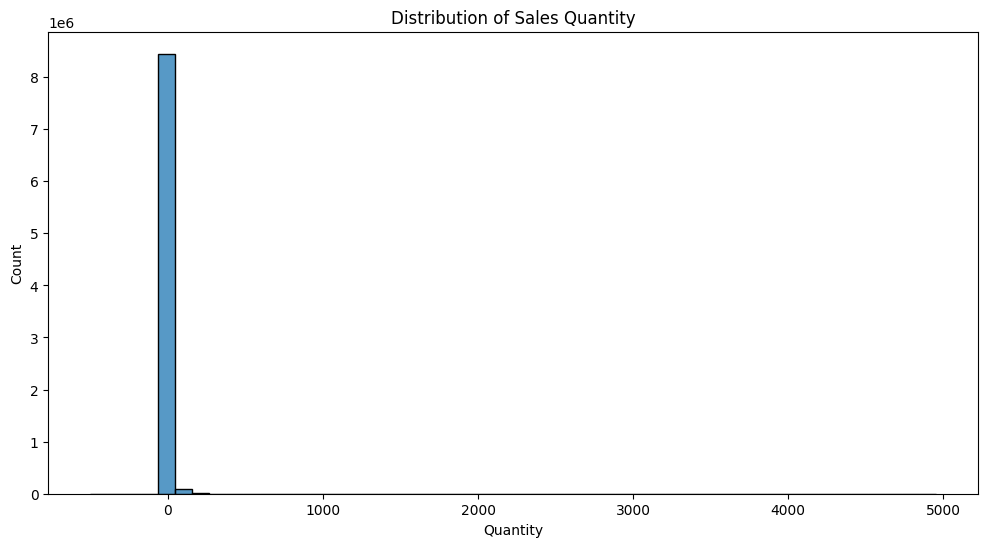

In [12]:
# Distribution of quantity
plt.figure(figsize=(12, 6))
sns.histplot(data=all_sales, x='quantity', bins=50)
plt.title('Distribution of Sales Quantity')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.show()

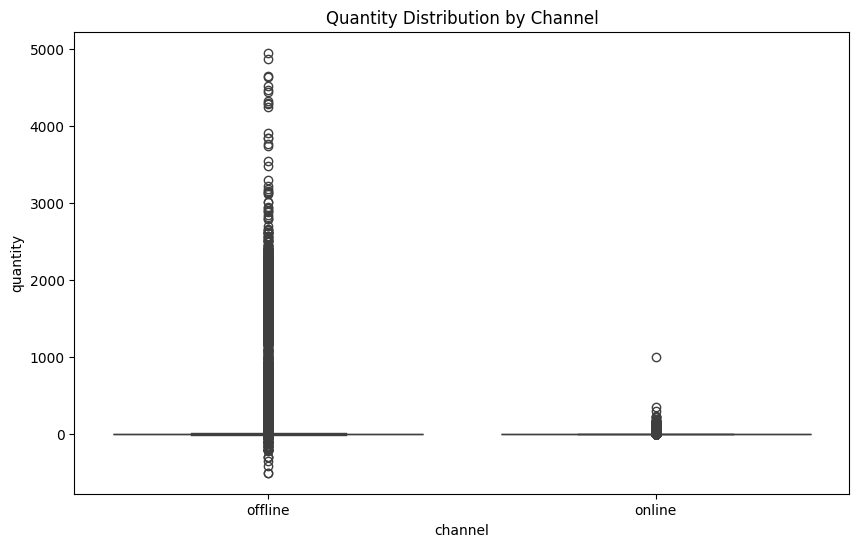

In [13]:
# Box plot of quantity by channel
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_sales, x='channel', y='quantity')
plt.title('Quantity Distribution by Channel')
plt.show()

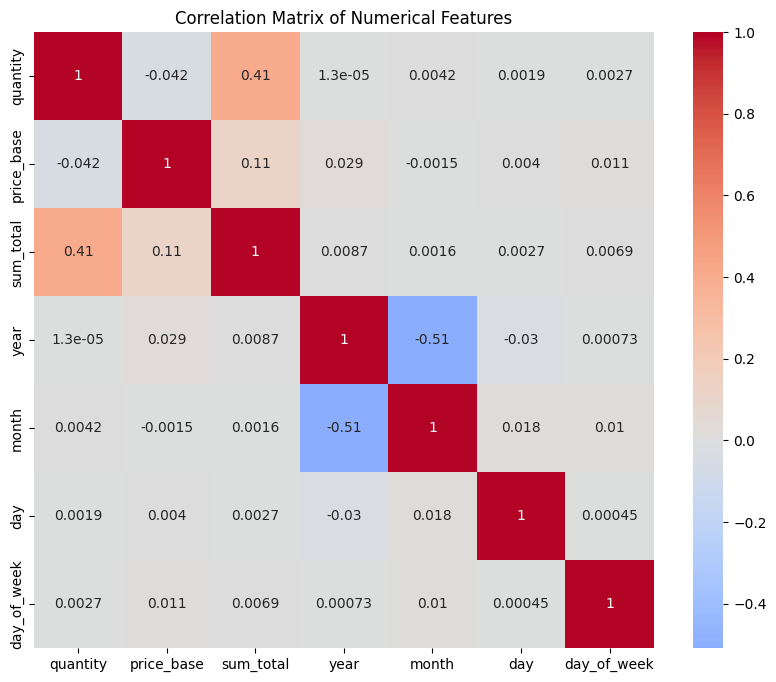

In [14]:
# Correlation analysis for numerical features
numerical_cols = ['quantity', 'price_base', 'sum_total', 'year', 'month', 'day', 'day_of_week']
correlation_matrix = all_sales[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


price and day_of_week could be a good indicator for prediction

In [15]:
# Average quantity by categorical features
categorical_analysis = []
for cat_col in ['channel', 'dept_name', 'class_name', 'format', 'city']:
    avg_quantity = all_sales.groupby(cat_col)['quantity'].mean().sort_values(ascending=False)
    print(f"\nAverage Quantity by {cat_col}:")
    print(avg_quantity.head())


Average Quantity by channel:
channel
offline    5.642398
online     2.194757
Name: quantity, dtype: float64

Average Quantity by dept_name:
dept_name
ВСПОМОГАТЕЛЬНАЯ ГРУППА    201.008619
ДОМАШНЯЯ КУХНЯ            192.094848
КАФЕ                       31.558320
ПИРОГИ                     22.577159
ЯЙЦО                       18.574995
Name: quantity, dtype: float64

Average Quantity by class_name:
class_name
ПЛАТНЫЕ ПАКЕТЫ     426.780408
ДОМАШНЯЯ КУХНЯ     192.094848
УСЛУГА И АРЕНДА    120.355187
БАНАНЫ              68.422704
АРБУЗЫ,ДЫНИ         41.033591
Name: quantity, dtype: float64

Average Quantity by format:
format
Format-7 express    5.725016
Format-1            5.497806
MaxiEuro            5.296386
Format-6            3.661610
Name: quantity, dtype: float64

Average Quantity by city:
city
City2    5.725016
City3    5.296386
City1    5.081295
Name: quantity, dtype: float64


Original data shape: (8556097, 15)
Filtered data shape: (8388037, 15)

Quantity range after filtering:
Min: 0.21
Max: 53.00


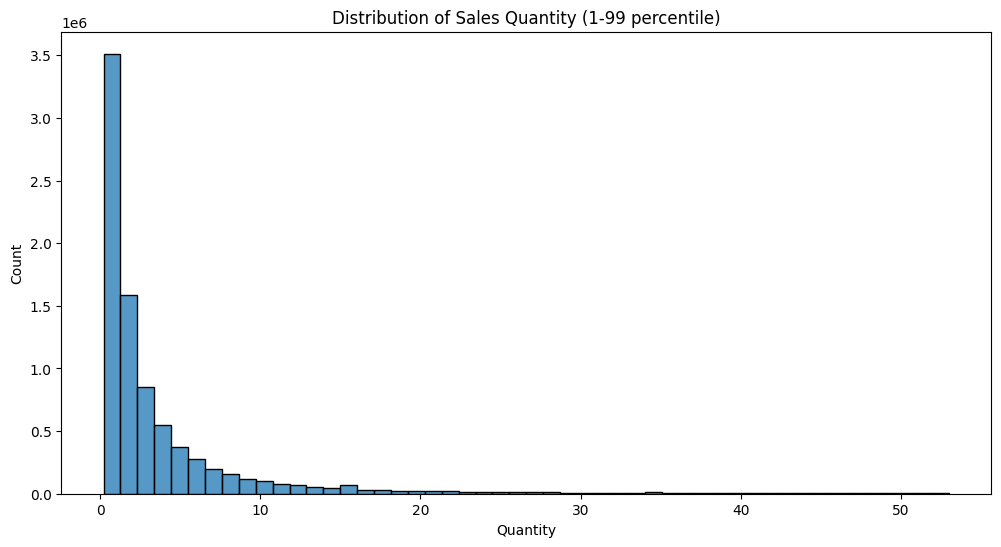

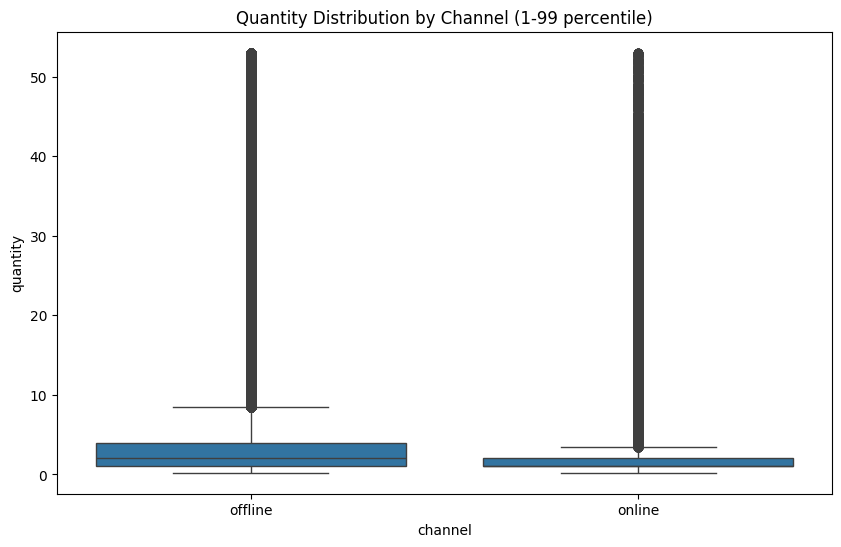

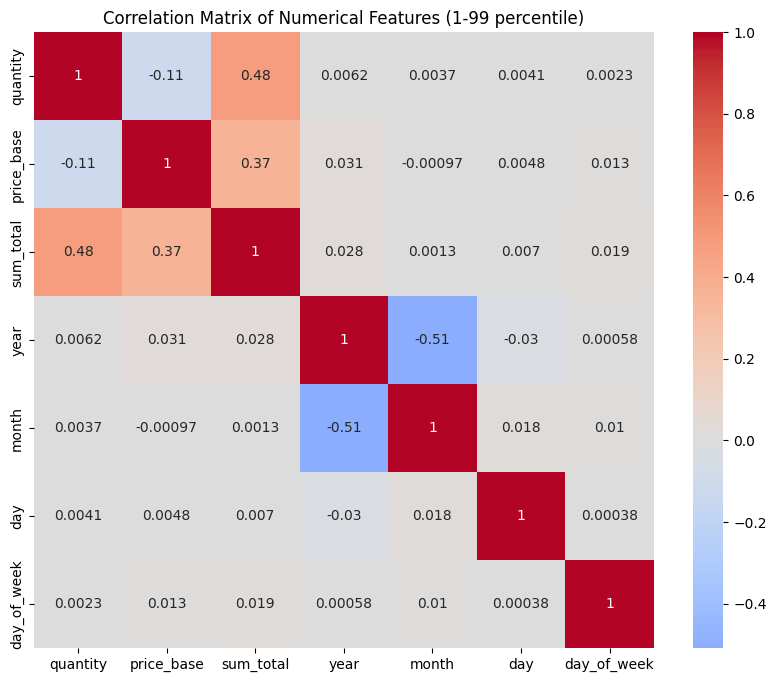

In [32]:
# Calculate 1st and 99th percentiles of quantity
q_low = all_sales['quantity'].quantile(0.01)
q_high = all_sales['quantity'].quantile(0.99)

# Filter the data
filtered_sales = all_sales[(all_sales['quantity'] >= q_low) & (all_sales['quantity'] <= q_high)]

print(f"Original data shape: {all_sales.shape}")
print(f"Filtered data shape: {filtered_sales.shape}")
print(f"\nQuantity range after filtering:")
print(f"Min: {filtered_sales['quantity'].min():.2f}")
print(f"Max: {filtered_sales['quantity'].max():.2f}")

# Plot distribution with filtered data
plt.figure(figsize=(12, 6))
sns.histplot(data=filtered_sales, x='quantity', bins=50)
plt.title('Distribution of Sales Quantity (1-99 percentile)')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.show()

# Box plot with filtered data
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_sales, x='channel', y='quantity')
plt.title('Quantity Distribution by Channel (1-99 percentile)')
plt.show()

# Correlation analysis with filtered data
numerical_cols = ['quantity', 'price_base', 'sum_total', 'year', 'month', 'day', 'day_of_week']
correlation_matrix = filtered_sales[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features (1-99 percentile)')
plt.show()

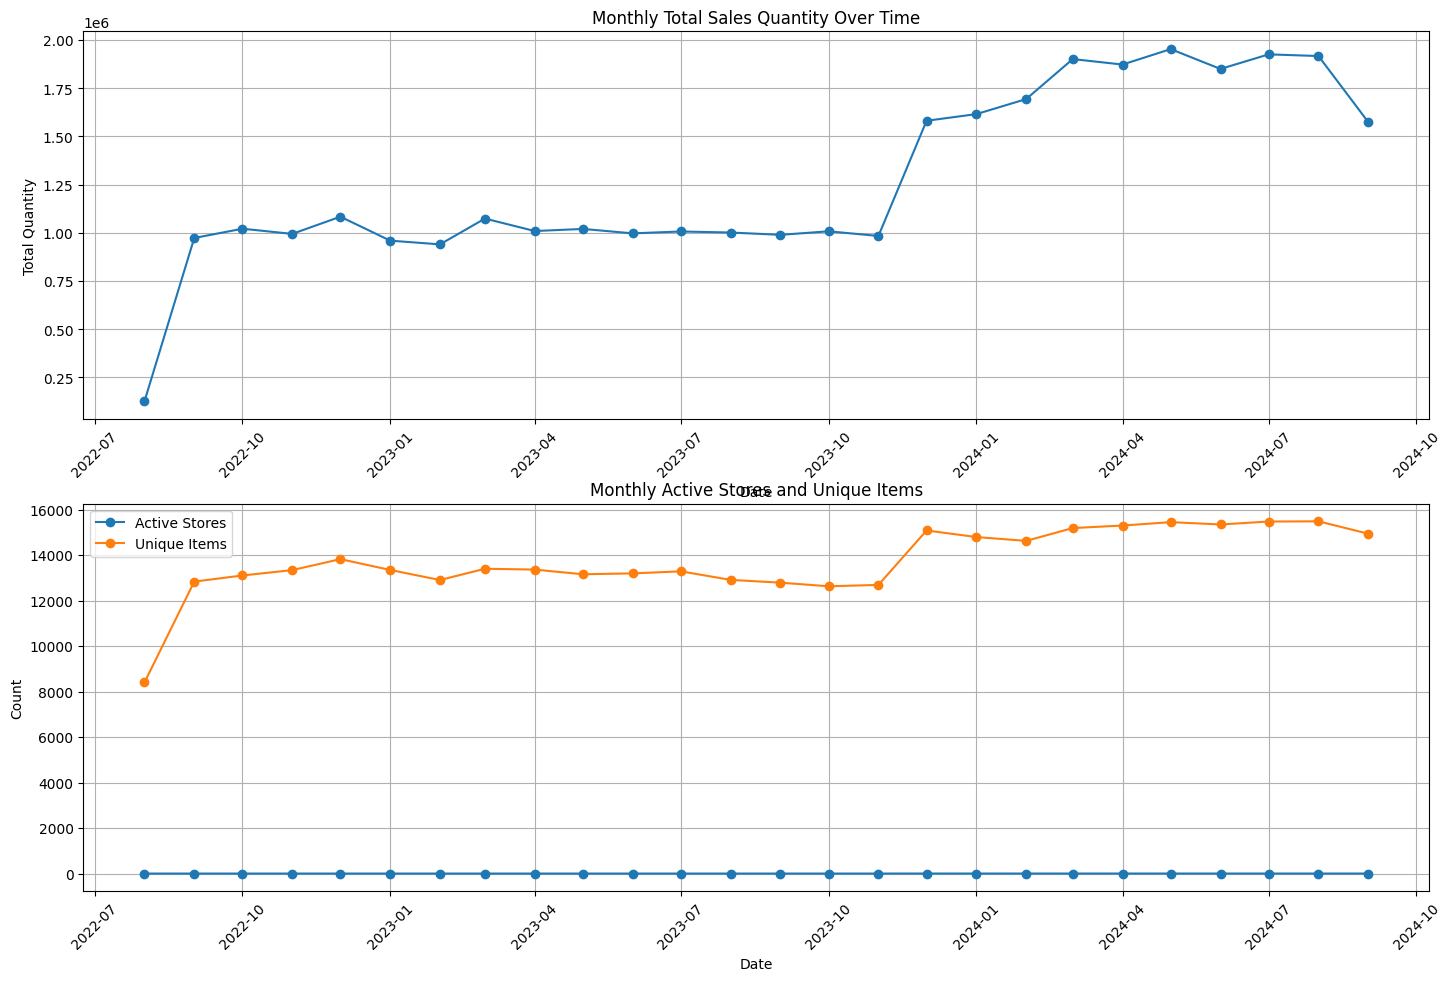


Monthly Sales Summary:
                                date      quantity   store_id       item_id
count                             26  2.600000e+01  26.000000     26.000000
mean   2023-08-16 14:46:09.230769152  1.272336e+06   3.384615  13726.000000
min              2022-08-01 00:00:00  1.263897e+05   3.000000   8402.000000
25%              2023-02-08 00:00:00  9.955174e+05   3.000000  12959.500000
50%              2023-08-16 12:00:00  1.021055e+06   3.000000  13356.000000
75%              2024-02-22 18:00:00  1.674465e+06   4.000000  15047.500000
max              2024-09-01 00:00:00  1.953119e+06   4.000000  15485.000000
std                              NaN  4.599530e+05   0.496139   1509.790873

Month-over-Month Growth Rates:
         date  quantity_pct_change
21 2024-05-01             4.277191
22 2024-06-01            -5.269199
23 2024-07-01             4.089778
24 2024-08-01            -0.448592
25 2024-09-01           -17.863934


In [33]:
# Convert date back to datetime if it's string
# filtered_sales['date'] = pd.to_datetime(filtered_sales['date'])

# Create monthly aggregation
monthly_sales = filtered_sales.groupby(filtered_sales['date'].dt.to_period('M')).agg({
    'quantity': 'sum',
    'store_id': 'nunique',  # number of active stores
    'item_id': 'nunique'    # number of unique items sold
}).reset_index()

# Convert period to datetime for plotting
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
fig.tight_layout(pad=4)

# Plot total quantity
ax1.plot(monthly_sales['date'], monthly_sales['quantity'], marker='o')
ax1.set_title('Monthly Total Sales Quantity Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Quantity')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Plot store and item counts
ax2.plot(monthly_sales['date'], monthly_sales['store_id'], marker='o', label='Active Stores')
ax2.plot(monthly_sales['date'], monthly_sales['item_id'], marker='o', label='Unique Items')
ax2.set_title('Monthly Active Stores and Unique Items')
ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.grid(True)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.show()

# Print summary statistics
print("\nMonthly Sales Summary:")
print(monthly_sales.describe())

# Calculate month-over-month growth
monthly_sales['quantity_pct_change'] = monthly_sales['quantity'].pct_change() * 100
print("\nMonth-over-Month Growth Rates:")
print(monthly_sales[['date', 'quantity_pct_change']].tail())

we could try using the sales since 202312 due to a rise in total quantity

# Model Training
1. LGBM
2. RandomForest

In [122]:
sales = pd.read_csv('../data/sales.csv', index_col=0)
online = pd.read_csv('../data/online.csv', index_col=0)
all_sales = pd.concat([sales, online], ignore_index=True)

In [123]:
# Group by date, store_id, item_id and aggregate
all_sales = all_sales.groupby(['date', 'store_id', 'item_id']).agg({
    'quantity': 'sum',
    'price_base': 'median'
}).reset_index()

In [124]:
all_sales.head()

,date,store_id,item_id,quantity,price_base
0,2022-08-28,1,001829cb707d,7.0,134.76
1,2022-08-28,1,0022b986c8f0,2.0,59.90
2,2022-08-28,1,002f51c34a7a,4.0,83.11
3,2022-08-28,1,0052403cd09c,1.0,45.70
4,2022-08-28,1,005addd8096b,2.0,77.25


In [125]:
# Convert date to datetime
all_sales['date'] = pd.to_datetime(all_sales['date'])
# Create basic time features
all_sales['year'] = all_sales['date'].dt.year
all_sales['month'] = all_sales['date'].dt.month
# all_sales['day'] = all_sales['date'].dt.day
all_sales['day_of_week'] = all_sales['date'].dt.dayofweek

In [126]:
all_sales['date'] = all_sales['date'].astype(str)
all_sales['store_id'] = all_sales['store_id'].astype(str)
all_sales['year'] = all_sales['year'].astype(str)
all_sales['month'] = all_sales['month'].astype(str)
# all_sales['day'] = all_sales['day'].astype(str)
all_sales['day_of_week'] = all_sales['day_of_week'].astype(str)

In [127]:
all_sales = all_sales.fillna('unknown')
all_sales.isna().sum()

date           0
store_id       0
item_id        0
quantity       0
price_base     0
year           0
month          0
day_of_week    0
dtype: int64

In [128]:
# Filter data after November 2023
# filtered_sales = all_sales[all_sales['date'] >= '2023-11-01']
filtered_sales = all_sales[all_sales['quantity'] > 0]

# Calculate 1st and 99th percentiles of quantity
# q_low = filtered_sales['quantity'].quantile(0.01)
# q_high = filtered_sales['quantity'].quantile(0.99)

# Filter the data
# filtered_sales = filtered_sales[(filtered_sales['quantity'] >= q_low) & (filtered_sales['quantity'] <= q_high)]

In [129]:
# Show the date range of filtered data
print("\nDate range in filtered data:")
print(f"Start date: {filtered_sales['date'].min()}")
print(f"End date: {filtered_sales['date'].max()}")
print(f"\nTotal records: {len(filtered_sales)}")


Date range in filtered data:
Start date: 2022-08-28
End date: 2024-09-26

Total records: 7646034


In [130]:
def train_val_test_split(df, target, train_size, val_size, test_size, random_state):
    
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    val_portion = val_size / (train_size + val_size)
    df_train, df_val = train_test_split(df_full_train, test_size=val_portion, random_state=random_state)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    del df_train[target]
    del df_val[target]
    del df_test[target]

    return df_full_train, df_train, df_test, df_val, y_train, y_val, y_test

In [131]:
df_full_train, df_train, df_test, df_val, y_train, y_val, y_test = \
    train_val_test_split(df=filtered_sales, target='quantity', train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

In [132]:
def train_lgbm(df_train, y_train, params=None):
    if params is None:
        # Simplified parameters for faster training
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 20,  # reduced from 31
            'learning_rate': 0.1,  # increased from 0.05
            'feature_fraction': 0.8,
            'num_threads': -1,  # Use all CPU cores
            'verbosity': -1  # Reduce verbosity
        }
    
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=True)
    X_train = dv.fit_transform(dicts)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    
    # Add progress bar
    print("Training LightGBM model...")
    model = lgb.train(
        params, 
        train_data, 
        num_boost_round=50,  # reduced from 100
        callbacks=[lgb.log_evaluation(period=10)]
    )
    
    return dv, model

In [133]:
# Train model
dv, lgb_model = train_lgbm(df_train, y_train)

Training LightGBM model...


In [134]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [135]:
# Make predictions on val
y_pred = predict(df_val, dv, lgb_model)
print('LightGBM RMSE:', round(rmse(y_val, y_pred), 3))

LightGBM RMSE: 12.878


In [136]:
# Make predictions on test
y_pred = predict(df_test, dv, lgb_model)
print('LightGBM RMSE:', round(rmse(y_test, y_pred), 3))

LightGBM RMSE: 12.716


In [139]:
test = pd.read_csv('../data/test.csv', sep=';')
test.head()

,row_id,item_id,store_id,date
0,0,c578da8e8841,1,27.09.2024
1,1,c578da8e8841,1,28.09.2024
2,2,c578da8e8841,1,29.09.2024
3,3,c578da8e8841,1,30.09.2024
4,4,c578da8e8841,1,01.10.2024


In [58]:
df_train.head()

,date,store_id,item_id,price_base,year,month,day_of_week
0,2024-08-01,4,09c375b4e892,68.71,2024,8,3
1,2024-09-23,1,95da83ab8f75,109.90,2024,9,0
2,2024-01-02,4,badb5d267d60,79.90,2024,1,1
3,2024-04-29,4,0ae0a1448a94,29.71,2024,4,0
4,2024-04-27,3,ff4431e6a727,17.90,2024,4,5


In [60]:
price_history.head()

,date,item_id,price,code,store_id
0,2023-08-01,4a1f95fe4d4b,499.9,1,1
1,2023-08-01,bf43a9d3ae13,0.0,9999999999,1
2,2023-08-01,0dd8744decce,129.9,1,1
3,2023-08-01,9b38c7e4dba9,136.0,1,1
4,2023-08-01,b791e8c9347c,0.0,1,1


In [137]:
def prepare_test_data(test_df):
    # Convert date to datetime
    test_df['date'] = pd.to_datetime(test_df['date'], format='%d.%m.%Y')
    
    # Create time features
    test_df['year'] = test_df['date'].dt.year
    test_df['month'] = test_df['date'].dt.month
    test_df['day_of_week'] = test_df['date'].dt.dayofweek
    
    # Convert to string type
    test_df['date'] = test_df['date'].astype(str)
    test_df['store_id'] = test_df['store_id'].astype(str)
    test_df['year'] = test_df['year'].astype(str)
    test_df['month'] = test_df['month'].astype(str)
    test_df['day_of_week'] = test_df['day_of_week'].astype(str)
    
    return test_df

In [140]:
processed_test = prepare_test_data(test)

In [141]:
# Get the last price for each item_id and store_id combination
last_prices = price_history.sort_values('date').groupby(['item_id', 'store_id'])['price'].last().reset_index()

In [142]:
last_prices['store_id'] = last_prices['store_id'].astype(str)

In [143]:
# Join with last prices
processed_test = processed_test.merge(last_prices, on=['item_id', 'store_id'], how='left')

In [144]:
print("\nMissing prices:")
print(processed_test['price'].isna().sum())


Missing prices:
57180


In [145]:
# Calculate median price by item_id from all_sales
item_median_prices = all_sales.groupby('item_id')['price_base'].median().reset_index()
item_median_prices = item_median_prices.rename(columns={'price_base': 'median_price'})

In [146]:
# Then fill remaining missing values with median prices from all_sales
processed_test = processed_test.merge(item_median_prices, on='item_id', how='left')

In [147]:
# Use median_price where price is missing
processed_test['price'] = processed_test['price'].fillna(processed_test['median_price'])

In [148]:
# Drop the temporary median_price column
processed_test = processed_test.drop('median_price', axis=1)

In [149]:
# Check if we still have missing prices
print("Missing prices after history median price imputation:")
print(processed_test['price'].isna().sum())

Missing prices after history median price imputation:
4230


In [150]:
catalog.head()

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,da17e2d5feda,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,БУМАЖНАЯ ПРОДУКЦИЯ,ВЛАЖНЫЕ САЛФЕТКИ,NaN,150.0,NaN,NaN
1,614de2b96018,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.0,NaN,NaN
2,0c1f1f3e3e11,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,NaN,NaN,NaN
3,71a7fa99f005,ТОВАРЫ ДЛЯ ДОМА,ПОСУДА,КУХОННАЯ ПОСУДА,NaN,NaN,NaN,NaN
4,ec1bd4d59fe9,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.0,NaN,NaN


In [151]:
# Merge catalog information
catalog_info = catalog[['item_id', 'dept_name', 'class_name']]

# Calculate median prices at different levels of granularity
dept_class_median = all_sales.merge(catalog_info, on='item_id', how='left').groupby(
    ['dept_name', 'class_name'])['price_base'].median().reset_index()
dept_median = all_sales.merge(catalog_info, on='item_id', how='left').groupby(
    ['dept_name'])['price_base'].median().reset_index()

# Add catalog info to processed_test
processed_test = processed_test.merge(catalog_info, on='item_id', how='left')

In [152]:
len(processed_test)

883680

In [153]:
# First try dept_class level median
processed_test = processed_test.merge(
    dept_class_median, 
    on=['dept_name', 'class_name'], 
    how='left',
    suffixes=('', '_dept_class')
)

In [154]:
# Then try dept level median
processed_test = processed_test.merge(
    dept_median, 
    on=['dept_name'], 
    how='left',
    suffixes=('', '_dept')
)

In [156]:
processed_test.head()

,row_id,item_id,store_id,date,year,month,day_of_week,price,dept_name,class_name,price_base,price_base_dept
0,0,c578da8e8841,1,2024-09-27,2024,9,4,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0
1,1,c578da8e8841,1,2024-09-28,2024,9,5,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0
2,2,c578da8e8841,1,2024-09-29,2024,9,6,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0
3,3,c578da8e8841,1,2024-09-30,2024,9,0,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0
4,4,c578da8e8841,1,2024-10-01,2024,10,1,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0


In [157]:
processed_test['price'] = processed_test['price'].fillna(processed_test['price_base_dept'])

In [158]:
processed_test['price'] = processed_test['price'].fillna(processed_test['price_base'])

In [159]:
processed_test['price'] = processed_test['price'].fillna(all_sales['price_base'].median())

In [160]:
print(processed_test['price'].isna().sum())

0


In [161]:
processed_test.head()

,row_id,item_id,store_id,date,year,month,day_of_week,price,dept_name,class_name,price_base,price_base_dept
0,0,c578da8e8841,1,2024-09-27,2024,9,4,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0
1,1,c578da8e8841,1,2024-09-28,2024,9,5,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0
2,2,c578da8e8841,1,2024-09-29,2024,9,6,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0
3,3,c578da8e8841,1,2024-09-30,2024,9,0,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0
4,4,c578da8e8841,1,2024-10-01,2024,10,1,279.0,ТАБАЧНЫЕ ИЗДЕЛИЯ,СИГАРЕТЫ,170.0,177.0


In [162]:
processed_test = processed_test[['date', 'store_id', 'item_id', 'price', 'year', 'month', 'day_of_week']]

In [163]:
test_predictions = predict(processed_test, dv, lgb_model)

In [164]:
submission = pd.DataFrame({
    'row_id': test['row_id'],
    'quantity': test_predictions
})

In [165]:
submission.to_csv('submission_lgbm_20250112.csv', index=False)

In [166]:
# !kaggle competitions submit -c ml-zoomcamp-2024-competition -f submission_lgbm_20250112.csv -m "lgbm_price_all_data"

100%|██████████████████████████████████████| 21.0M/21.0M [00:01<00:00, 20.6MB/s]
Successfully submitted to ML Zoomcamp 2024 Competition

The base submission can get 20.1906

Training Random Forest model...

Random Forest Performance:
RMSE: 13.0780
R2 Score: 0.7718

LightGBM Performance:
RMSE: 12.8777
R2 Score: 0.7787

Top 10 Most Important Features (Random Forest):
                    feature  importance
19996  item_id=b0d24502fb66    0.391287
28470            store_id=4    0.167281
28467            store_id=1    0.153800
6280   item_id=327c5bc1e583    0.062226
11568  item_id=63161948a95a    0.053331
17626  item_id=9a7e315f3f42    0.033524
28466            price_base    0.026839
1796   item_id=0973df3ff57f    0.011286
766           day_of_week=5    0.010080
765           day_of_week=4    0.009427


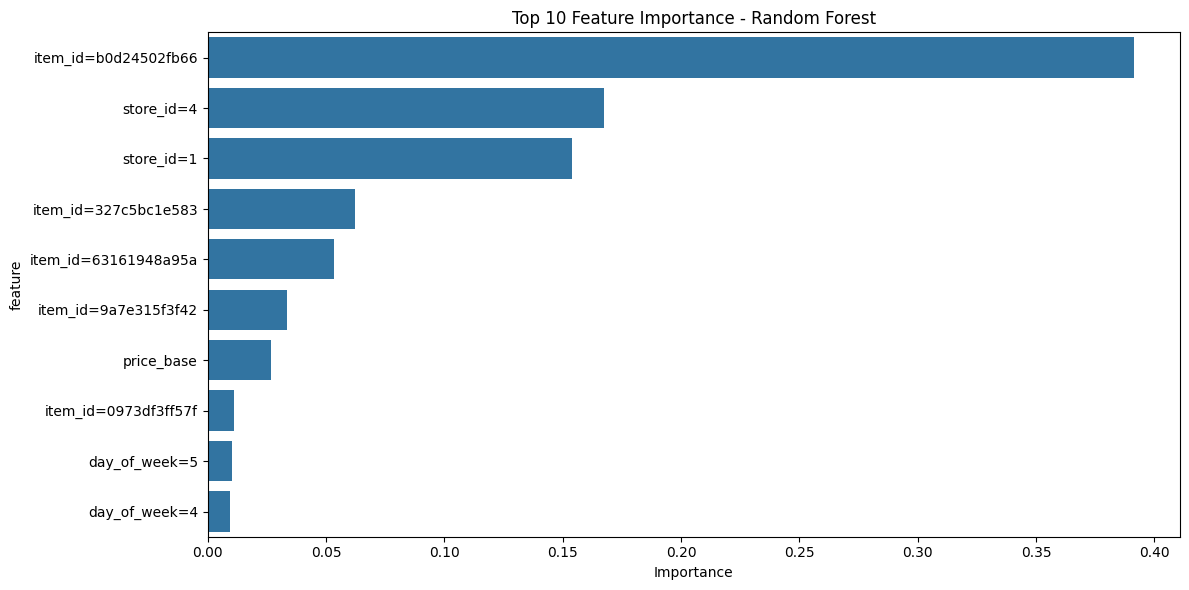

In [168]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare features for Random Forest
def prepare_features_rf(df, dv):
    # Transform categorical variables
    X = dv.transform(df.to_dict(orient='records'))
    return X

# Train Random Forest model
def train_rf_model(X_train, y_train):
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    return rf_model

# Make predictions
def predict_rf(df, dv, model):
    X = prepare_features_rf(df, dv)
    return model.predict(X)

# Train the model
print("Training Random Forest model...")
X_train = prepare_features_rf(df_train, dv)
X_val = prepare_features_rf(df_val, dv)

rf_model = train_rf_model(X_train, y_train)

# Make predictions on validation set
val_pred_rf = predict_rf(df_val, dv, rf_model)

# Calculate metrics
rmse_rf = np.sqrt(mean_squared_error(y_val, val_pred_rf))
r2_rf = r2_score(y_val, val_pred_rf)

print("\nRandom Forest Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R2 Score: {r2_rf:.4f}")

# Compare with LightGBM performance
val_pred_lgb = predict(df_val, dv, lgb_model)
rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
r2_lgb = r2_score(y_val, val_pred_lgb)

print("\nLightGBM Performance:")
print(f"RMSE: {rmse_lgb:.4f}")
print(f"R2 Score: {r2_lgb:.4f}")

# Feature importance for Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': dv.get_feature_names_out(),
    'importance': rf_model.feature_importances_
})
feature_importance_rf = feature_importance_rf.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_rf.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [169]:
test_predictions = predict_rf(processed_test, dv, rf_model)
submission = pd.DataFrame({
    'row_id': test['row_id'],
    'quantity': test_predictions
})
submission.to_csv('submission_rf_20250112.csv', index=False)

In [170]:
# !kaggle competitions submit -c ml-zoomcamp-2024-competition -f submission_rf_20250112.csv -m "rf_price_all_data"

100%|██████████████████████████████████████| 21.8M/21.8M [00:00<00:00, 26.8MB/s]
Successfully submitted to ML Zoomcamp 2024 Competition

The random forest has better result of 18.47

# Parameter Tuning

Training Random Forest models with different parameters...


  0%|                                                                              | 0/1 [00:00<?, ?it/s]

Fitting 3 folds for each of 8 candidates, totalling 24 fits


100%|████████████████████████████████████████████████████████████████████| 1/1 [24:40<00:00, 1480.62s/it]



Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: 5.13

Tuned Random Forest Performance:
Validation RMSE: 26.0048
Test RMSE: 25.8822

Previous Random Forest Performance:
Validation RMSE: 13.078

Top 10 Most Important Features (Tuned Random Forest):
                    feature  importance
19996  item_id=b0d24502fb66    0.084648
28466            price_base    0.063840
11568  item_id=63161948a95a    0.058874
6280   item_id=327c5bc1e583    0.049961
17626  item_id=9a7e315f3f42    0.046984
4181   item_id=1f14dfe5d045    0.045434
5841   item_id=2e58990eaa3c    0.039630
2948   item_id=14115307ac40    0.029391
25621  item_id=e5b2b6f57ea7    0.028898
20503  item_id=b5aac3497e3f    0.024198


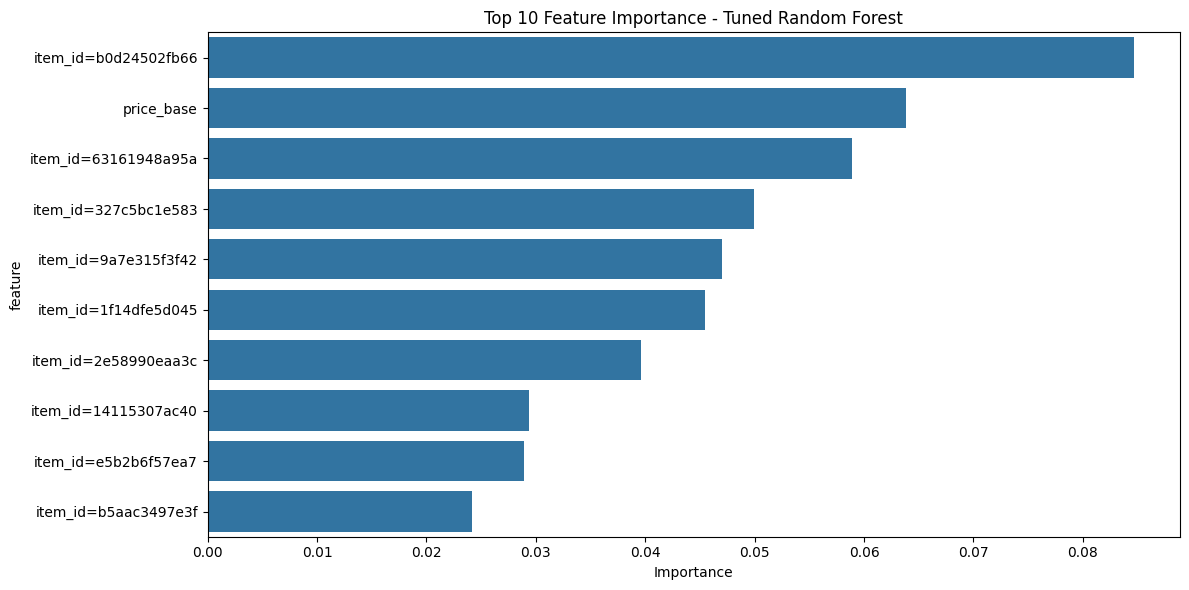

In [172]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from tqdm import tqdm

# Custom RMSE scorer
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2],
    'max_features': ['sqrt']
}

# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Initialize GridSearchCV with custom scorer
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=make_scorer(rmse_scorer, greater_is_better=False),
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Prepare features
X_train = prepare_features_rf(df_train, dv)
X_val = prepare_features_rf(df_val, dv)

# Fit GridSearchCV
print("Training Random Forest models with different parameters...")
with tqdm(total=1) as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(1)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best RMSE:", round((-grid_search.best_score_)**0.5, 3))

# Make predictions with best model
best_rf_model = grid_search.best_estimator_
val_pred_rf_tuned = best_rf_model.predict(X_val)
test_pred_rf_tuned = best_rf_model.predict(prepare_features_rf(df_test, dv))

# Calculate metrics for validation and test sets
print("\nTuned Random Forest Performance:")
print(f"Validation RMSE: {round(rmse(y_val, val_pred_rf_tuned), 4)}")
print(f"Test RMSE: {round(rmse(y_test, test_pred_rf_tuned), 4)}")

# Compare with previous results
print("\nPrevious Random Forest Performance:")
print(f"Validation RMSE: {round(rmse_rf, 4)}")

# Feature importance for tuned model
feature_importance_rf_tuned = pd.DataFrame({
    'feature': dv.get_feature_names_out(),
    'importance': best_rf_model.feature_importances_
})
feature_importance_rf_tuned = feature_importance_rf_tuned.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Tuned Random Forest):")
print(feature_importance_rf_tuned.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_rf_tuned.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance - Tuned Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [173]:
# test_predictions = predict_rf(processed_test, dv, rf_model)
test_predictions = best_rf_model.predict(prepare_features_rf(processed_test, dv))
submission = pd.DataFrame({
    'row_id': test['row_id'],
    'quantity': test_predictions
})
submission.to_csv('submission_rf_para_20250112.csv', index=False)

In [174]:
!kaggle competitions submit -c ml-zoomcamp-2024-competition -f submission_rf_para_20250112.csv -m "rf_best_model_all_data"

100%|██████████████████████████████████████| 21.7M/21.7M [00:00<00:00, 30.6MB/s]
Successfully submitted to ML Zoomcamp 2024 Competition

The parameter tuning give us 30.96.